# use lstm predict rent

- 以某个SA2区域做的预测
- 对未来几年的租金进行预测，需要相应的population，median_rent等数据（该数据怎么获取可讨论，简单分析可通过线性回归预测每一年的值）
- 当前只有年度单位的数据，数据量很少，是否可以细分到月或者天

* 1. 加载数据集、数据可视化、预处理
* 2. 特征工程
* 3. 构建模型
* 4. 模型编译、训练、验证

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras import Sequential, layers, utils, losses
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import warnings
warnings.filterwarnings('ignore')

### 第1步：加载数据集、预处理

In [2]:
# 加载数据集

dataset = pd.read_csv(r"../data/curated/history_info.csv", parse_dates=['year'], dtype={'SA2': str}, index_col=0)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3507 entries, 0 to 3506
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   SA2          3507 non-null   object        
 1   year         3507 non-null   datetime64[ns]
 2   population   3507 non-null   int64         
 3   bond         3507 non-null   float64       
 4   price_index  3507 non-null   int64         
 5   median_rent  3507 non-null   float64       
 6   deal_count   3507 non-null   int64         
 7   to_USD       3507 non-null   float64       
 8   immi_count   3507 non-null   int64         
 9   debt_ratio   3507 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 301.4+ KB


In [4]:
dataset = dataset[dataset["SA2"] == "202011022"].reset_index(drop=True)


In [5]:
# 数据集大小

dataset.shape

(7, 10)

In [6]:
# 默认显示前5行

dataset.head()

,SA2,year,population,bond,price_index,median_rent,deal_count,to_USD,immi_count,debt_ratio
0,202011022,2013-01-01,19377,2.96,109,277.50,3822,0.8948,122250,0.860
1,202011022,2014-01-01,19563,2.28,115,280.00,3967,0.8202,128170,0.855
2,202011022,2015-01-01,19742,2.10,126,278.75,4139,0.7306,140220,0.850
3,202011022,2016-01-01,19947,1.97,140,280.75,4094,0.7236,159630,1.015
4,202011022,2017-01-01,20180,2.03,154,287.50,3831,0.7800,161170,1.180


In [7]:
# 默认显示后5行

dataset.tail()

,SA2,year,population,bond,price_index,median_rent,deal_count,to_USD,immi_count,debt_ratio
2,202011022,2015-01-01,19742,2.10,126,278.75,4139,0.7306,140220,0.850
3,202011022,2016-01-01,19947,1.97,140,280.75,4094,0.7236,159630,1.015
4,202011022,2017-01-01,20180,2.03,154,287.50,3831,0.7800,161170,1.180
5,202011022,2018-01-01,20422,1.93,144,300.00,3553,0.7058,168310,1.145
6,202011022,2019-01-01,20690,0.77,150,312.50,3297,0.7006,150630,1.110


In [8]:
# 数据集信息

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   SA2          7 non-null      object        
 1   year         7 non-null      datetime64[ns]
 2   population   7 non-null      int64         
 3   bond         7 non-null      float64       
 4   price_index  7 non-null      int64         
 5   median_rent  7 non-null      float64       
 6   deal_count   7 non-null      int64         
 7   to_USD       7 non-null      float64       
 8   immi_count   7 non-null      int64         
 9   debt_ratio   7 non-null      float64       
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 688.0+ bytes


In [9]:
# 数据集描述

dataset.describe()

,population,bond,price_index,median_rent,deal_count,to_USD,immi_count,debt_ratio
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,19988.714286,2.005714,134.000000,288.142857,3814.714286,0.765086,147197.142857,1.002143
std,471.551239,0.649278,17.521415,13.271097,300.885756,0.071495,17513.930374,0.146539
min,19377.000000,0.770000,109.000000,277.500000,3297.000000,0.700600,122250.000000,0.850000
25%,19652.500000,1.950000,120.500000,279.375000,3687.500000,0.714700,134195.000000,0.857500
50%,19947.000000,2.030000,140.000000,280.750000,3831.000000,0.730600,150630.000000,1.015000
75%,20301.000000,2.190000,147.000000,293.750000,4030.500000,0.800100,160400.000000,1.127500
max,20690.000000,2.960000,154.000000,312.500000,4139.000000,0.894800,168310.000000,1.180000


### 第2步：数据集可视化

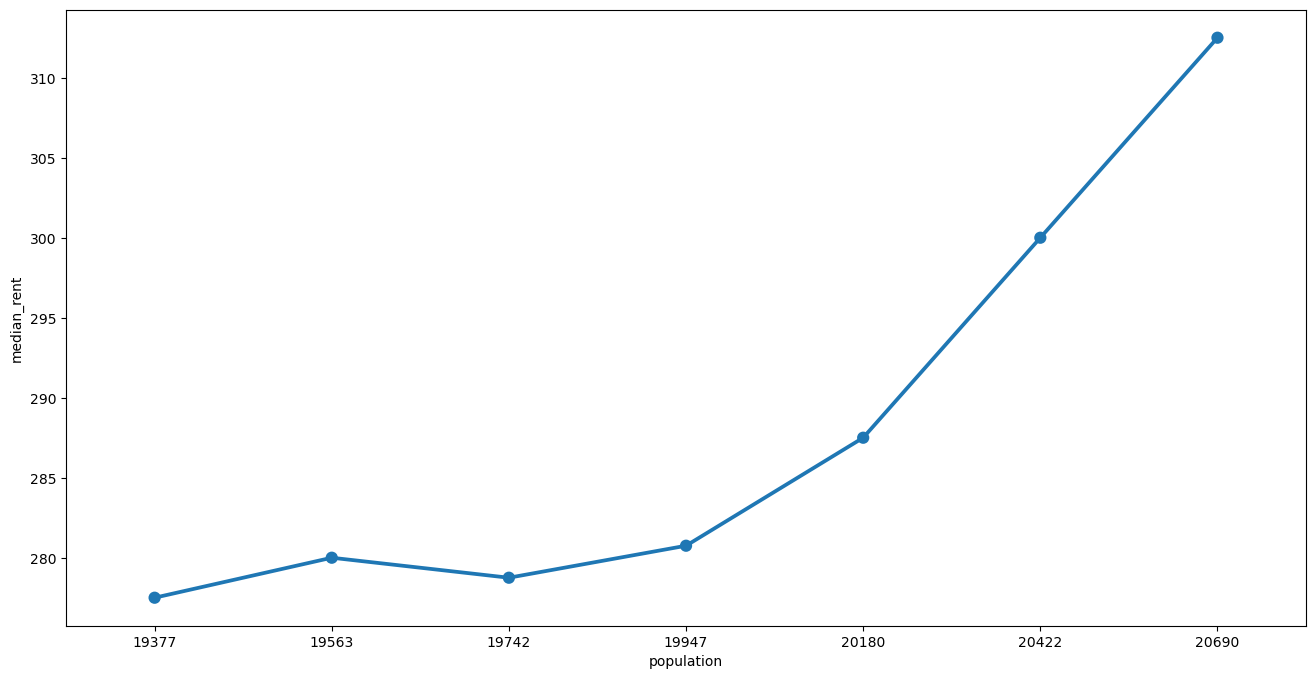

In [10]:
plt.figure(figsize=(16,8))
sns.pointplot(x='population', y='median_rent', data=dataset)
plt.show()

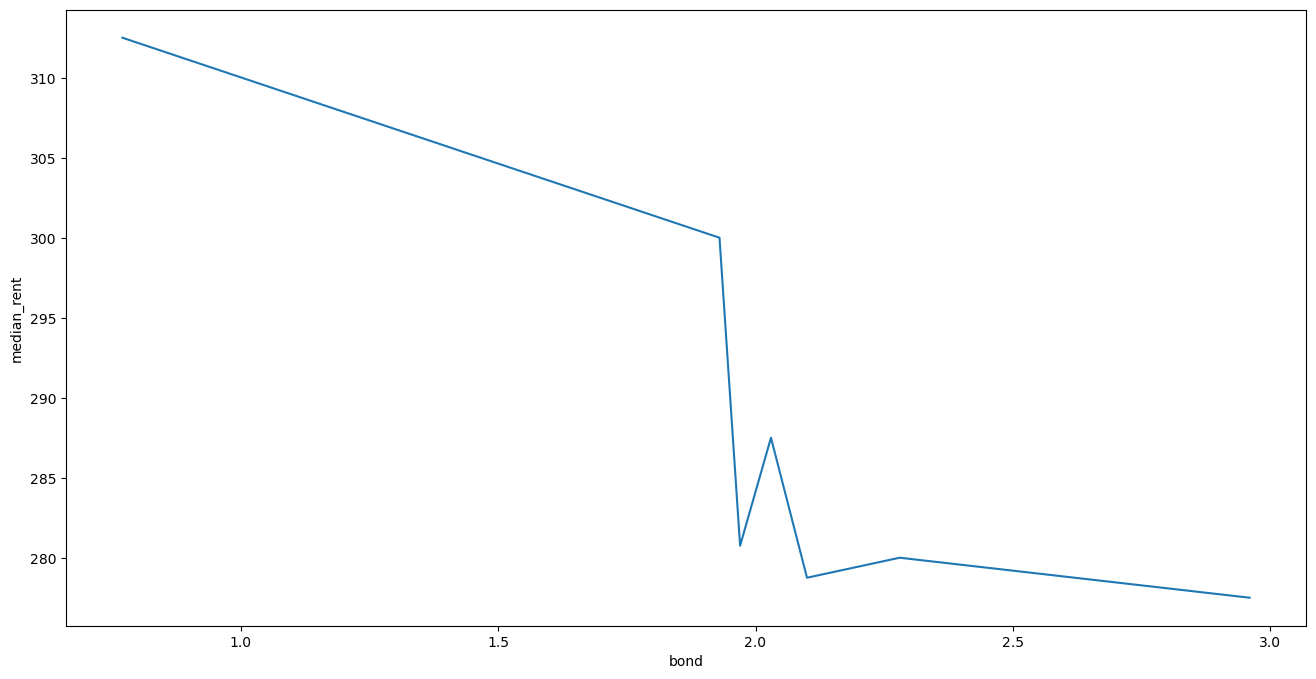

In [11]:
plt.figure(figsize=(16,8))
sns.lineplot(x='bond', y='median_rent', data=dataset)
plt.show()

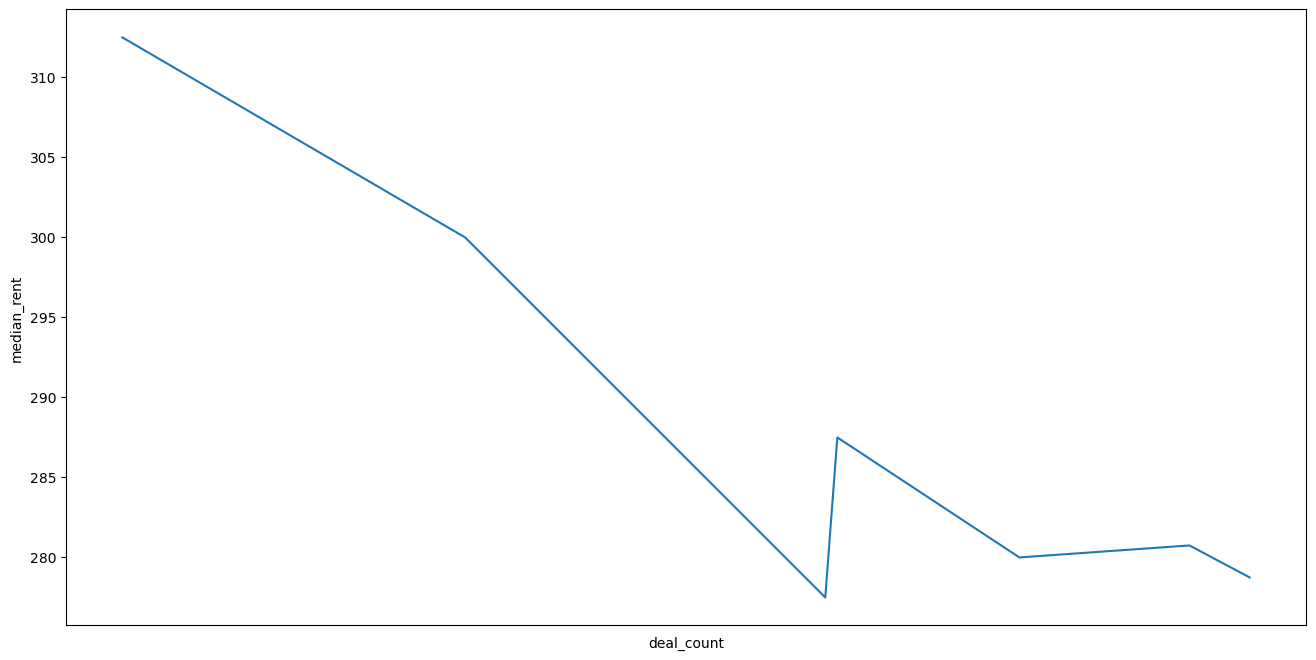

In [12]:
plt.figure(figsize=(16,8))
sns.lineplot(x='deal_count', y='median_rent', data=dataset)
plt.xticks([])
plt.show()

In [13]:
dataset.drop(columns=['SA2'], axis=1, inplace=True)

In [14]:
dataset.set_index(keys='year', inplace=True)

In [15]:
dataset.head()

,population,bond,price_index,median_rent,deal_count,to_USD,immi_count,debt_ratio
year,,,,,,,,
2013-01-01,19377,2.96,109,277.50,3822,0.8948,122250,0.860
2014-01-01,19563,2.28,115,280.00,3967,0.8202,128170,0.855
2015-01-01,19742,2.10,126,278.75,4139,0.7306,140220,0.850
2016-01-01,19947,1.97,140,280.75,4094,0.7236,159630,1.015
2017-01-01,20180,2.03,154,287.50,3831,0.7800,161170,1.180


In [16]:
# 分别对字段t1, t2, hum, wind_speed进行归一化

columns = ['population', 'bond', 'price_index', 'deal_count', 'to_USD', 
           'immi_count', 'debt_ratio', 'median_rent']

for col in columns:
    scaler = MinMaxScaler()
    dataset[col] = scaler.fit_transform(dataset[col].values.reshape(-1,1))

In [17]:
dataset.head()

,population,bond,price_index,median_rent,deal_count,to_USD,immi_count,debt_ratio
year,,,,,,,,
2013-01-01,0.000000,1.000000,0.000000,0.000000,0.623515,1.000000,0.000000,0.030303
2014-01-01,0.141660,0.689498,0.133333,0.071429,0.795724,0.615860,0.128528,0.015152
2015-01-01,0.277989,0.607306,0.377778,0.035714,1.000000,0.154480,0.390143,0.000000
2016-01-01,0.434120,0.547945,0.688889,0.092857,0.946556,0.118435,0.811550,0.500000
2017-01-01,0.611577,0.575342,1.000000,0.285714,0.634204,0.408857,0.844985,1.000000


### 第4步：特征工程

In [18]:
# 特征数据集

X = dataset.drop(columns=['median_rent'], axis=1)

# 标签数据集

y = dataset['median_rent']

In [19]:
X.shape

(7, 7)

In [20]:
y.shape

(7,)

In [21]:
# 1 数据集分离： X_train, X_test
# 数据量太少不区分训练集测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=666)
# X_train, y_train = X, y

In [22]:
X_train.shape

(5, 7)

In [23]:
y_train.shape

(5,)

In [24]:
X_train.head()

,population,bond,price_index,deal_count,to_USD,immi_count,debt_ratio
year,,,,,,,
2013-01-01,0.000000,1.000000,0.000000,0.623515,1.000000,0.000000,0.030303
2014-01-01,0.141660,0.689498,0.133333,0.795724,0.615860,0.128528,0.015152
2015-01-01,0.277989,0.607306,0.377778,1.000000,0.154480,0.390143,0.000000
2016-01-01,0.434120,0.547945,0.688889,0.946556,0.118435,0.811550,0.500000
2017-01-01,0.611577,0.575342,1.000000,0.634204,0.408857,0.844985,1.000000


In [25]:
# 2 构造特征数据集

def create_dataset(X, y, seq_len=1):
    features = []
    targets = []
    for i in range(0, len(X) - seq_len):
        data = X.iloc[i:i+seq_len] # 序列数据
        label = y.iloc[i+seq_len] # 标签数据
        # 保存到features和labels
        features.append(data)
        targets.append(label)
    # 返回
    return np.array(features), np.array(targets)

In [26]:
# 构造训练特征数据集

train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=1)

In [27]:
train_dataset.shape

(4, 1, 7)

In [28]:
train_labels.shape

(4,)

In [29]:
# ② 构造测试特征数据集

test_dataset, test_labels = create_dataset(X_test, y_test, seq_len=1)

In [30]:
# 3 构造批数据

def create_batch_dataset(X, y, train=True, buffer_size=1000, batch_size=128):
    batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # 数据封装，tensor类型
    if train: # 训练集
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else: # 测试集
        return batch_data.batch(batch_size)

In [31]:
# 训练批数据

train_batch_dataset = create_batch_dataset(train_dataset, train_labels)

In [32]:
# 测试批数据

test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)

In [33]:
# 从测试批数据中，获取一个batch_size的样本数据

list(train_batch_dataset.as_numpy_iterator())[0]

(array([[[0.        , 1.        , 0.        , 0.62351544, 1.        ,
          0.        , 0.03030303]],
 
        [[0.27798934, 0.60730594, 0.37777778, 1.        , 0.15447992,
          0.39014329, 0.        ]],
 
        [[0.43412034, 0.54794521, 0.68888889, 0.94655582, 0.1184346 ,
          0.81155015, 0.5       ]],
 
        [[0.14166032, 0.68949772, 0.13333333, 0.79572447, 0.61585994,
          0.12852801, 0.01515152]]]),
 array([0.07142857, 0.09285714, 0.28571429, 0.03571429]))

In [34]:
list(test_batch_dataset.as_numpy_iterator())[0]

(array([[[0.79588728, 0.52968037, 0.77777778, 0.304038  , 0.02677652,
          1.        , 0.89393939]]]),
 array([1.]))

### 第5步：模型搭建、编译、训练

In [35]:
# 模型搭建--版本1

model = Sequential([
    layers.LSTM(units=32, input_shape=train_dataset.shape[-2:], return_sequences=True),
    layers.Dropout(0.4),
    layers.Dense(1)
])

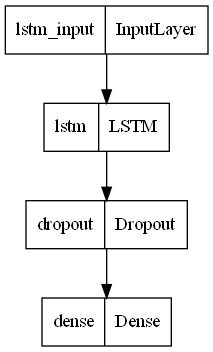

In [36]:
# 显示模型结构

utils.plot_model(model)

In [37]:
# 模型编译

model.compile(optimizer='adam',
              loss='mse')

In [38]:
# 保存模型权重文件和训练日志
log_file = '.\\logs\\'

tensorboard_callback = TensorBoard(log_file)

In [39]:
checkpoint_file = "best_model.hdf5"

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file, 
                                      monitor='loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)

In [40]:
# 模型训练

history = model.fit(train_batch_dataset,
                    epochs=3,

                    callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/3
1/1 [==============================] - 1s 1s/step - loss: 0.0527
Epoch 2/3
1/1 [==============================] - 0s 9ms/step - loss: 0.0516
Epoch 3/3
1/1 [==============================] - 0s 9ms/step - loss: 0.0349


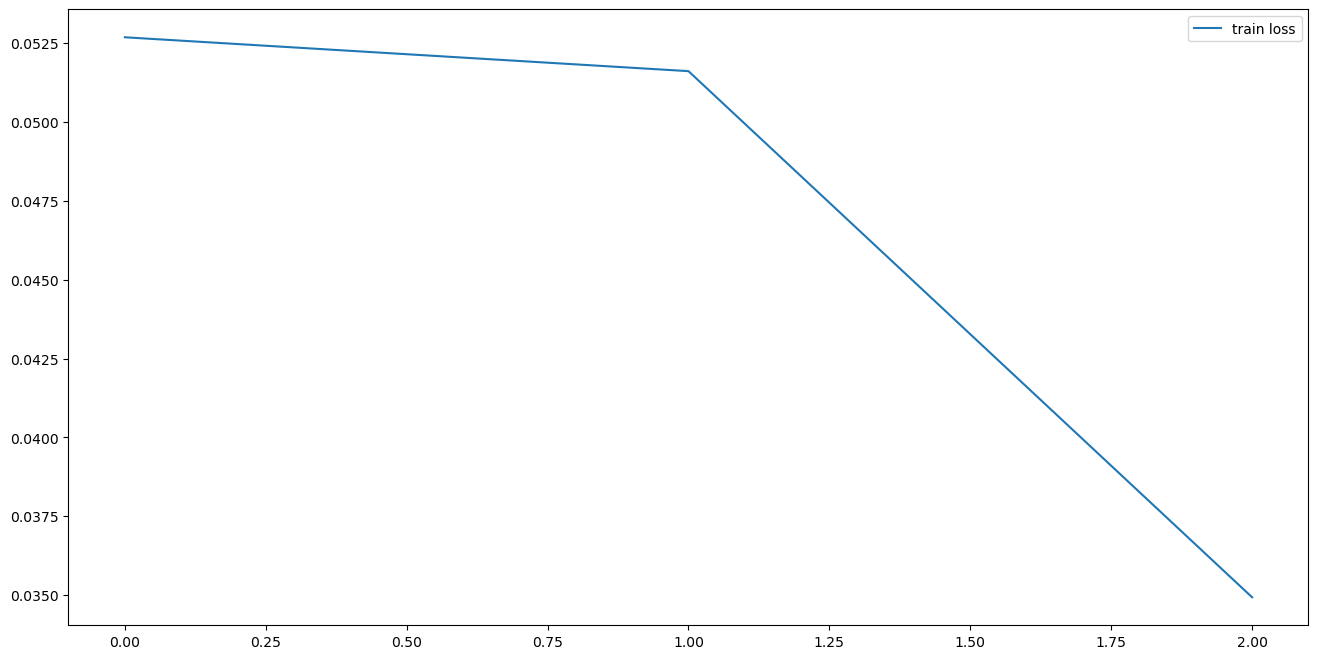

In [41]:
# 显示训练结果

plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.legend(loc='best')
plt.show()